## Looking at Results and Errors

It would be useful for us to clearly understand what sort of errors our network is making and think about ways we might correct or better handle these errors. In this notebook we'll run our current best model and look at what it's getting wrong.

## Train our Best Learner

In [35]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from fastai.train import ClassificationInterpretation
from fastai.vision import Path, ImageList, imagenet_stats, cnn_learner, get_transforms, DatasetType, models, load_learner, fbeta
import sklearn.metrics
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from EasyDict import EasyDict
import utils

In [30]:
np.random.seed(42)
torch.manual_seed(0)

In [31]:
NFOLDS = 5
script_name = os.path.basename('01_BasicModel').split('.')[0]
MODEL_NAME = "{0}__folds{1}".format(script_name, NFOLDS)
print("Model: {}".format(MODEL_NAME))

# Make required folders if they're not already present
directories = ['kfolds', 'model_predictions', 'model_source']
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

Model: 01_BasicModel__folds5


In [32]:
DATA = Path('data')
WORK = Path('work')

CSV_TRN_MERGED = DATA/'train_merged.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'

TRN_CURATED = DATA/'train_curated2'
TRN_NOISY = DATA/'train_noisy2'
TRN_MERGED = DATA/'train_merged'

IMG_TRN_CURATED = WORK/'image/trn_curated2'
IMG_TRN_NOISY = WORK/'image/trn_noisy2'
IMG_TEST = WORK/'image/test'

TEST = DATA/'test'

train = pd.read_csv(DATA/'train_curated.csv')
test = pd.read_csv(DATA/'sample_submission.csv')
train_noisy = pd.read_csv(DATA/'train_noisy.csv')
train_merged = pd.read_csv(DATA/'train_merged.csv')

In [5]:
X = train['fname']
y = train['labels'].apply(lambda f: f.split(','))
y_noisy = train_noisy['labels'].apply(lambda f: f.split(','))
transformed_y = MultiLabelBinarizer().fit_transform(y)
transformed_y_noisy = MultiLabelBinarizer().fit_transform(y_noisy)
filenames = train['fname'].values
filenames = filenames.reshape(-1, 1)

oof_preds = np.zeros((len(train), 80))
test_preds = np.zeros((len(test), 80))

tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)

mskf = MultilabelStratifiedKFold(n_splits=5, random_state=4, shuffle=True)
_, val_index = next(mskf.split(X, transformed_y))

In [52]:
train[train['fname'] == '3127fec6.wav']

fname                    labels
934  3127fec6.wav  Gurgling,Chink_and_clink

In [6]:
#Our clasifier stuff    
src = (ImageList.from_csv(WORK/'image', Path('../../')/CSV_TRN_MERGED, folder='trn_merged', suffix='.jpg')
    .split_by_idx(val_index)
    .label_from_df(cols=list(train_merged.columns[1:]))
      )

data = (src.transform(tfms, size=128).databunch(bs=64).normalize())

In [138]:
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.xresnet101, pretrained=False, metrics=[f_score]).mixup(stack_y=False)
learn.fit_one_cycle(100, 1e-2)

KeyboardInterrupt: 

## Looking at Errors

Now that we've trained a model we want to look at what it's getting wrong. Since this is a multilabel problem there are a few ways we could define what the model gets "Most Incorrect":
 - The largest single loss for any prediction (which individual sounds does it mix up)
 - The largest aggregate loss for an entire clip (which clip does it predict the most poorly)
 - The largest aggregate loss for an entire category (which sound does it struggle the most on)

In [37]:
preds, y_True, losses = learn.get_preds(ds_type=DatasetType.Valid, with_loss=True)

In [38]:
reshapedLosses = losses.view_as(preds)
reshapedLosses.shape

torch.Size([1001, 80])

In [39]:
def convertToDims(index, rows, cols):
    row = (index // cols) 
    col = index - (row * cols)
    return row, col

In [123]:
def getInfoOnTopLoss(preds, y_True, losses, reshapedLosses, index):
    

Loss: tensor(6.4442)
Category: Chink_and_clink
Correct: tensor(1.)
Our Prediction: tensor(0.0016)

Labels: (Image (3, 128, 128), MultiCategory Chink_and_clink;Gurgling)


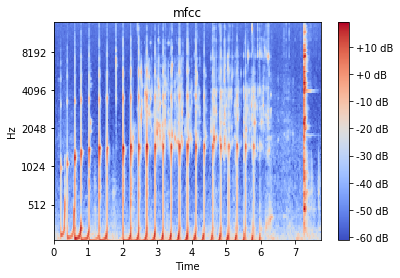

Loss: tensor(6.4291)
Category: Tick-tock
Correct: tensor(1.)
Our Prediction: tensor(0.0016)

Labels: (Image (3, 128, 128), MultiCategory Tick-tock)


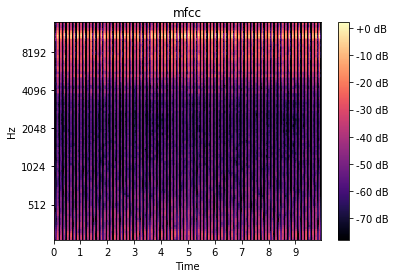

Loss: tensor(6.2527)
Category: Cutlery_and_silverware
Correct: tensor(1.)
Our Prediction: tensor(0.0019)

Labels: (Image (3, 128, 128), MultiCategory Cutlery_and_silverware;Dishes_and_pots_and_pans)


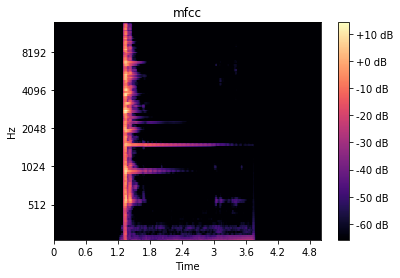

Loss: tensor(6.0426)
Category: Slam
Correct: tensor(1.)
Our Prediction: tensor(0.0024)

Labels: (Image (3, 128, 128), MultiCategory Slam;Squeak)


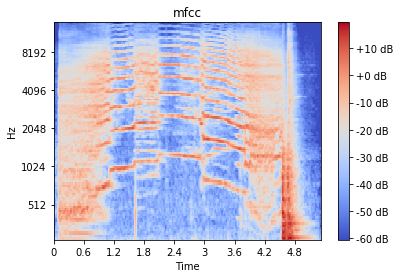

Loss: tensor(5.9147)
Category: Printer
Correct: tensor(1.)
Our Prediction: tensor(0.0027)

Labels: (Image (3, 128, 128), MultiCategory Printer)


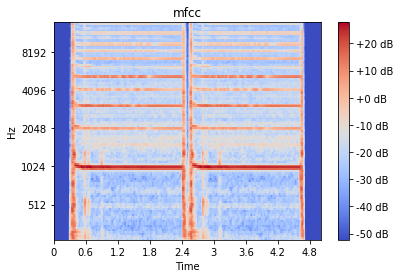

In [137]:
toplosses, toplosses_indexes = torch.topk(losses, 5)

for index in toplosses_indexes:
    # row represents the clip that contains this large loss
    # col represents the category that was misclassified and generated the large loss
    row, col = convertToDims(index, reshapedLosses.shape[0], reshapedLosses.shape[1])
    
    print("Loss:", reshapedLosses[row][col])
    print("Category:", learn.data.classes[col])
    print("Correct:", y_True[row][col])
    print("Our Prediction:", preds[row][col])
    print()
    print("Labels:", learn.data.valid_ds[row])
    
    filename = learn.data.valid_ds.x.items[row].split('/')[-1].replace('.jpg', '')
    path = TRN_MERGED/filename
    
    conf = EasyDict()
    conf.sampling_rate = 32000
    conf.duration = 5
    conf.hop_length = 500 # So that there are 64 frames per second
    conf.fmin = 50
    conf.fmax = 14000
    conf.n_mels = 128
    conf.n_fft = conf.n_mels * 20

    conf.samples = conf.sampling_rate * conf.duration
    
    _ = utils.read_as_melspectrogram(conf, path, trim_long_data=False, debug_display=True)
        

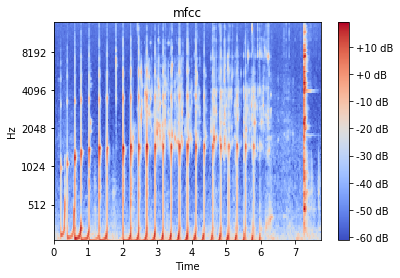

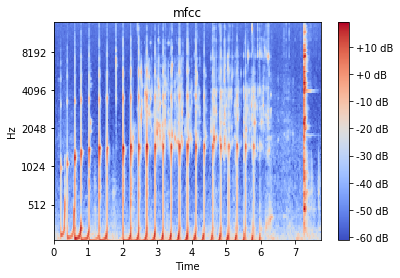

array([[-22.983952, -23.383408, -25.27616 , -23.687828, ..., -25.804287, -23.421906, -21.637882, -24.66611 ],
       [-20.04534 , -19.416042, -19.935787, -19.235891, ..., -26.940773, -25.57022 , -23.885887, -27.137863],
       [-25.70275 , -25.150234, -22.94615 , -22.46495 , ..., -27.16549 , -24.035328, -22.816456, -24.525537],
       [-31.544199, -28.26074 , -24.05948 , -23.803144, ..., -23.74053 , -25.32707 , -26.240479, -25.30336 ],
       ...,
       [-51.81623 , -52.163136, -53.188046, -52.216774, ..., -51.12098 , -51.597515, -53.395943, -52.938484],
       [-51.568542, -51.957703, -52.710793, -52.208405, ..., -51.139732, -52.094852, -53.07585 , -52.04802 ],
       [-51.243416, -51.266537, -50.569225, -50.331497, ..., -49.988834, -51.93052 , -52.56466 , -51.541893],
       [-51.265003, -50.741955, -51.30146 , -52.132862, ..., -50.7403  , -51.4257  , -52.180668, -50.835293]],
      dtype=float32)

In [122]:
utils.read_as_melspectrogram(conf, path, trim_long_data=False, debug_display=True)

In [73]:
reshapedLosses[row][col]

tensor(6.4442)

In [76]:
y_True[row][col]

tensor(1.)

In [75]:
preds[row][col]

tensor(0.0016)

In [65]:
learn.data.valid_ds.x.items[row]

'work/image/trn_merged/3127fec6.wav.jpg'

(Image (3, 128, 128), MultiCategory Chink_and_clink;Gurgling)

In [69]:
preds[row][col]

tensor(0.0016)

In [102]:
ourPredictions = preds[row][preds[row] > 0.5]
preds[row]

tensor([0.0021, 0.0017, 0.0015, 0.0015, 0.0025, 0.0019, 0.0058, 0.0052, 0.0019,
        0.0074, 0.0009, 0.0051, 0.0117, 0.0041, 0.2220, 0.0029, 0.0016, 0.0059,
        0.0014, 0.0021, 0.0963, 0.0181, 0.0018, 0.0024, 0.0019, 0.0009, 0.0011,
        0.0007, 0.2460, 0.0016, 0.0082, 0.0017, 0.0029, 0.0669, 0.0043, 0.0020,
        0.0143, 0.0023, 0.0030, 0.6486, 0.0021, 0.0016, 0.0018, 0.0154, 0.0171,
        0.0018, 0.0050, 0.0036, 0.0067, 0.0022, 0.0010, 0.0132, 0.0011, 0.0038,
        0.0015, 0.0254, 0.0181, 0.0069, 0.0035, 0.0163, 0.0128, 0.0066, 0.0083,
        0.0010, 0.0039, 0.0054, 0.0020, 0.0012, 0.0057, 0.0013, 0.0128, 0.0008,
        0.0342, 0.0245, 0.0043, 0.0015, 0.0038, 0.0078, 0.0040, 0.0195])

In [95]:
correctPredictions = learn.data.classes[col]
correctPredictions

'Chink_and_clink'

In [48]:
x = 
x

'work/image/trn_merged/3127fec6.wav.jpg'

PosixPath('data/train_merged/3127fec6.wav')

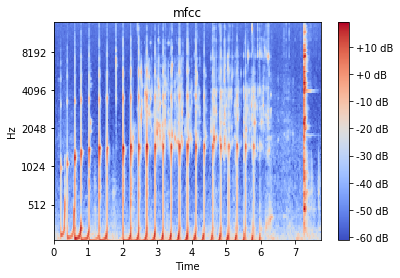

array([[-22.983952, -23.383408, -25.27616 , -23.687828, ..., -25.804287, -23.421906, -21.637882, -24.66611 ],
       [-20.04534 , -19.416042, -19.935787, -19.235891, ..., -26.940773, -25.57022 , -23.885887, -27.137863],
       [-25.70275 , -25.150234, -22.94615 , -22.46495 , ..., -27.16549 , -24.035328, -22.816456, -24.525537],
       [-31.544199, -28.26074 , -24.05948 , -23.803144, ..., -23.74053 , -25.32707 , -26.240479, -25.30336 ],
       ...,
       [-51.81623 , -52.163136, -53.188046, -52.216774, ..., -51.12098 , -51.597515, -53.395943, -52.938484],
       [-51.568542, -51.957703, -52.710793, -52.208405, ..., -51.139732, -52.094852, -53.07585 , -52.04802 ],
       [-51.243416, -51.266537, -50.569225, -50.331497, ..., -49.988834, -51.93052 , -52.56466 , -51.541893],
       [-51.265003, -50.741955, -51.30146 , -52.132862, ..., -50.7403  , -51.4257  , -52.180668, -50.835293]],
      dtype=float32)

579 misclassified samples over 1001 samples in the validation set.


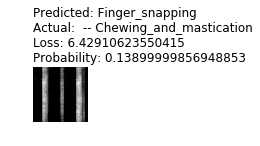

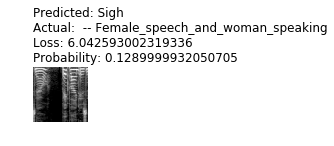

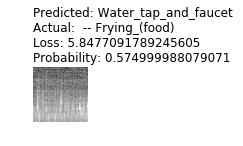

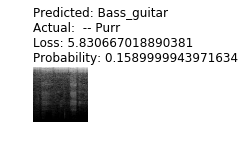

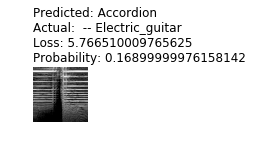

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_multi_top_losses(5, figsize=(1,1))

Unfortunately, we can't really listen to these sounds directly. Instead we'll have to try to manually map them back to their filenames.